In [2]:
print('Ali Nikkhah')
print('99102445')

Ali Nikkhah
99102445


# 1. Transfer learning `ResNet50`

in this notebook we intend to implement transfer learning with a classifier with feature extractor using `Cross Entropy`, using `Triplet loss` and at the end using both cross entropy and triplet loss

## Loading and prepairing dataset

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")

using cpu device


100%|██████████| 170498071/170498071 [00:03<00:00, 48877570.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training examples for 'airplane' and 'car': 10000
Number of test examples for 'airplane' and 'car': 2000


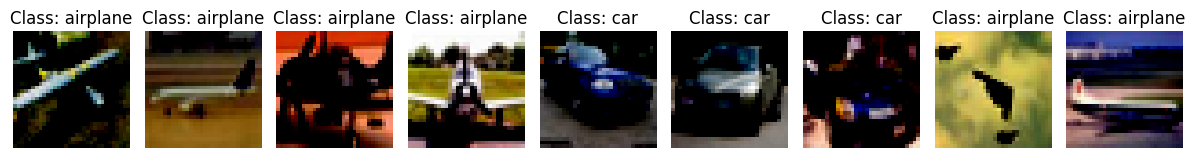

In [5]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import random
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
cifar10_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
selected_classes = [0, 1]  # 0: airplane, 1: car
num_classes = len(selected_classes)
filtered_indices = [i for i in range(len(cifar10_dataset.targets)) if cifar10_dataset.targets[i] in selected_classes]
filtered_train_dataset = torch.utils.data.Subset(cifar10_dataset, filtered_indices)
filtered_test_indices = [i for i in range(len(cifar10_test_dataset.targets)) if cifar10_test_dataset.targets[i] in selected_classes]
filtered_test_dataset = Subset(cifar10_test_dataset, filtered_test_indices)
batch_size = 32
train_loader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False)
print(f"Number of training examples for 'airplane' and 'car': {len(filtered_train_dataset)}")
print(f"Number of test examples for 'airplane' and 'car': {len(filtered_test_dataset)}")
num_samples_to_display = 9
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(12, 3))
random_indices = random.sample(range(len(filtered_train_dataset)), num_samples_to_display)
for i, idx in enumerate(random_indices):
    image, label = filtered_train_dataset[idx]
    class_name = 'airplane' if label == 0 else 'car'
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Performing Transfer Learning

in the next part we initialize a resNet50 model with it's pretrained weights for IMAGENET and change it's fully connected layer to perform for our 2 class problem

In [6]:
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: airplane and automobile
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
train_loss_values = []
train_accuracy_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {epoch_loss:.4f} - Training Accuracy: {epoch_accuracy:.2f}%")
    train_loss_values.append(epoch_loss)
    train_accuracy_values.append(epoch_accuracy)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


Epoch [1/5] - Training Loss: 0.4227 - Training Accuracy: 81.35%
Epoch [2/5] - Training Loss: 0.3552 - Training Accuracy: 85.07%
Epoch [3/5] - Training Loss: 0.3480 - Training Accuracy: 85.62%
Epoch [4/5] - Training Loss: 0.3476 - Training Accuracy: 85.68%
Epoch [5/5] - Training Loss: 0.3271 - Training Accuracy: 86.16%


## Plottting trained model performance

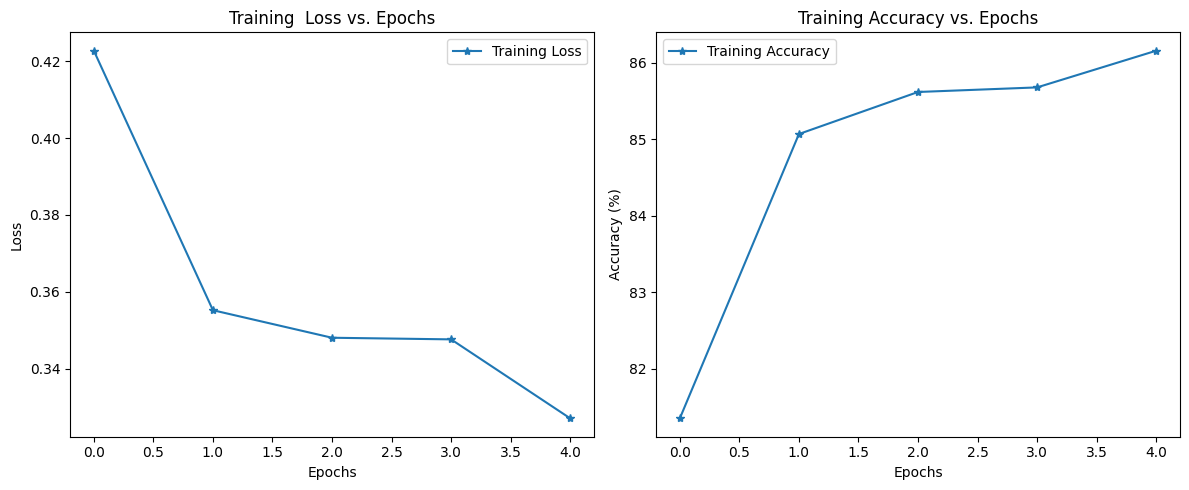

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_values, label='Training Loss', marker="*")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training  Loss vs. Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracy_values, label='Training Accuracy', marker="*")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.tight_layout()
plt.show()

* as you can see, accuracy increases and loss decreases during training, which suggests a fine training process. final value of accuracy obtained is `86.16`% over only 5 epochs



# 2. Training Using Triplet loss approach

* as you know, training on Triplet Loss criterion needs custom `TripletDataLoader` for creating custom dataset with sudo-labels anchor,positive,negative.


In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader
import numpy as np
class TripletDataset(Dataset):
    def __init__(self, root_dir='./data', train=True, selected_classes=[0, 1], transform=None):
        """
        Initialize TripletDataset with specified parameters.

        Args:
        - root_dir (str): Root directory for dataset. Default: './data'
        - train (bool): Boolean indicating whether it's a training dataset or not. Default: True
        - selected_classes (list): List of selected classes. Default: [0, 1]
        - transform (callable, optional): Optional transform to be applied to the data. Default: None
        """
        self.root_dir = root_dir
        self.transform = transform
        self.cifar10_dataset = datasets.CIFAR10(
            root=self.root_dir,
            train=train,
            download=True,
            transform=transform
        )
        self.filtered_indices = [i for i in range(len(self.cifar10_dataset.targets)) if self.cifar10_dataset.targets[i] in selected_classes]
        self.filtered_dataset = Subset(self.cifar10_dataset, self.filtered_indices)
    def __getitem__(self, index):
        """
        Retrieve triplets of anchor, positive, negative samples and their labels.

        Args:
        - index (int): Index to retrieve the triplet samples.

        Returns:
        - anchor (tensor): Anchor sample
        - positive (tensor): Positive sample
        - negative (tensor): Negative sample
        - anchor_label: Label of the anchor sample
        """
        anchor, anchor_label = self.filtered_dataset[index]
        original_targets = torch.tensor(self.cifar10_dataset.targets)[self.filtered_indices]
        positive_indices = torch.nonzero(original_targets == anchor_label).squeeze()
        positive_index = np.random.choice(positive_indices.numpy())
        positive, _ = self.filtered_dataset[positive_index]
        negative_indices = torch.nonzero(original_targets != anchor_label).squeeze()
        negative_index = np.random.choice(negative_indices.numpy())
        negative, _ = self.filtered_dataset[negative_index]
        return anchor, positive, negative, anchor_label
    def __len__(self):
        """
        Return the length of the filtered dataset.

        Returns:
        - length (int): Length of the filtered dataset
        """
        return len(self.filtered_dataset)
triplet_train_dataset = TripletDataset(
    root_dir='./triplet',
    train=True,
    selected_classes=[0, 1],
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Change transform
)
triplet_test_dataset = TripletDataset(
    root_dir='./triplet',
    train=False,
    selected_classes=[0, 1],
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Change transform
)
batch_size = 32
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training examples: {len(triplet_train_dataset)}")
print(f"Number of test examples: {len(triplet_test_dataset)}")


100%|██████████| 170498071/170498071 [00:03<00:00, 48923632.03it/s]


Extracting ./triplet/cifar-10-python.tar.gz to ./triplet
Files already downloaded and verified
Number of training examples: 10000
Number of test examples: 2000


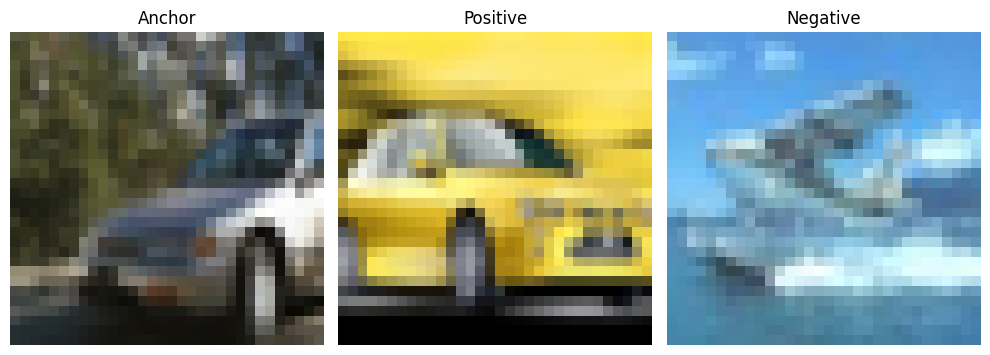

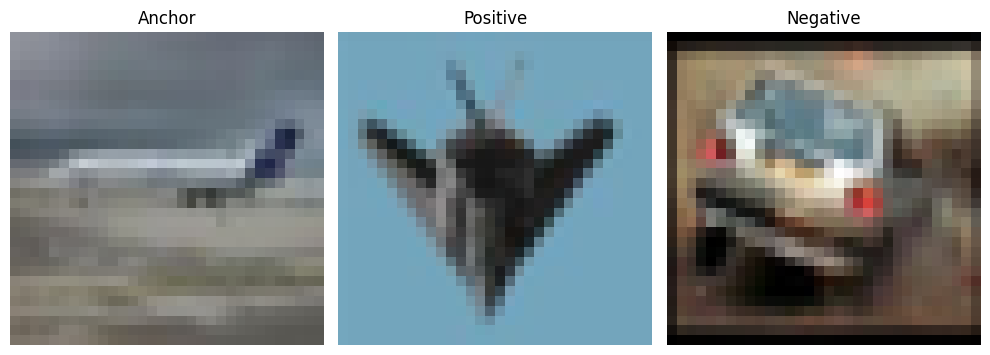

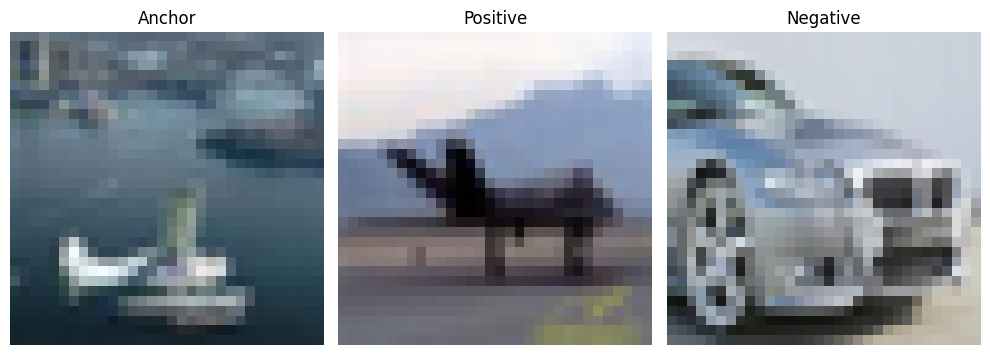

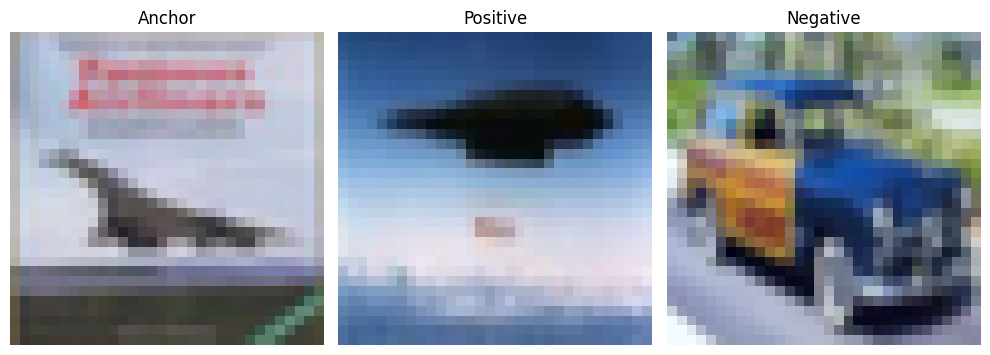

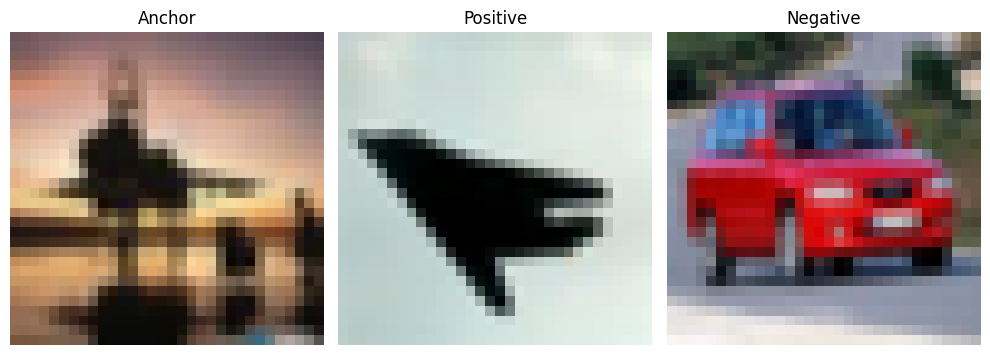

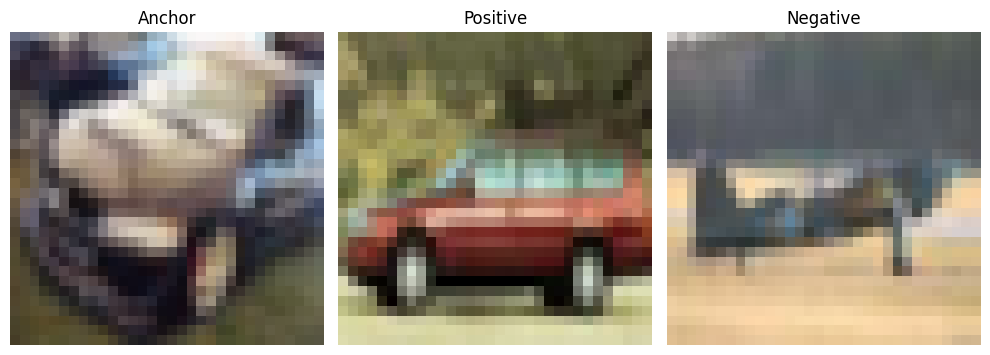

In [12]:
import matplotlib.pyplot as plt
def show_triplet_samples(anchor, positive, negative):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    '''WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).'''
    anchor = anchor / 2 + 0.5
    positive = positive / 2 + 0.5
    negative = negative / 2 + 0.5
    axes[0].imshow(anchor.permute(1, 2, 0))
    axes[0].set_title('Anchor')
    axes[0].axis('off')
    axes[1].imshow(positive.permute(1, 2, 0))
    axes[1].set_title('Positive')
    axes[1].axis('off')
    axes[2].imshow(negative.permute(1, 2, 0))
    axes[2].set_title('Negative')
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()
for i, (anchor, positive, negative, _) in enumerate(triplet_train_loader):
    if i < 3:
        show_triplet_samples(anchor[0], positive[0], negative[0])
    else:
        break
for i, (anchor, positive, negative, _) in enumerate(triplet_test_loader):
    if i < 3:
        show_triplet_samples(anchor[0], positive[0], negative[0])
    else:
        break


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
resnet50 = models.resnet50(weights='DEFAULT')
resnet50.fc=nn.Identity()
triplet_loss = nn.TripletMarginLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)
scheduler    = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 5/5: 100%|██████████| 313/313 [10:00<00:00,  1.92s/batch, Loss=0.0339]


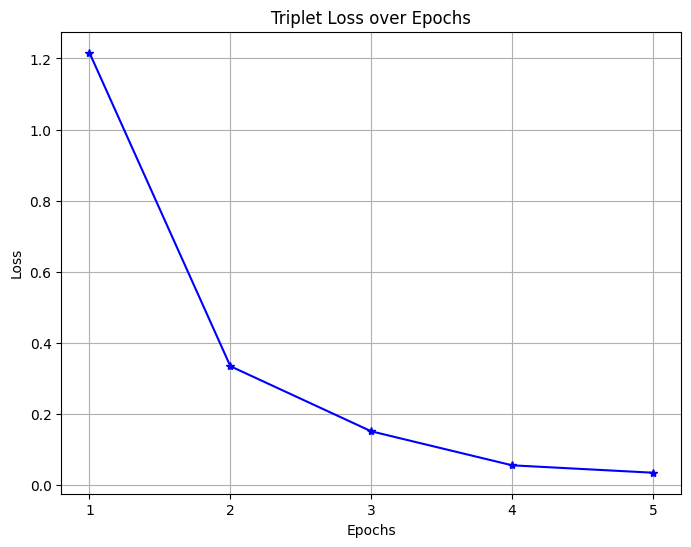

In [24]:
from tqdm import tqdm
num_epochs = 5
loss_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    resnet50.train()
    pbar = tqdm(triplet_train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for i, (anchor, positive, negative, _) in enumerate(pbar):
        optimizer.zero_grad()
        anchor_embeddings = resnet50(anchor)
        positive_embeddings = resnet50(positive)
        negative_embeddings = resnet50(negative)
        loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({"Loss": running_loss / (i + 1)})
    epoch_loss = running_loss / len(triplet_train_loader)
    loss_values.append(epoch_loss)
    scheduler.step()
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='*', linestyle='-', color='b')
plt.title('Triplet Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid(True)
plt.show()


* we observe a highly decreasing loss over the plot, which suggests we did a good job training the model.

## adding Fully connected layer classifier

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Linear(num_features, num_classes)
num_features = resnet50.fc.in_features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

Epoch 1/5: 100%|██████████| 313/313 [02:55<00:00,  1.78it/s]

Epoch 2/5: 100%|██████████| 313/313 [02:56<00:00,  1.78it/s]

Epoch 3/5: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]

Epoch 4/5: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]

Epoch 5/5: 100%|██████████| 313/313 [02:57<00:00,  1.77it/s]


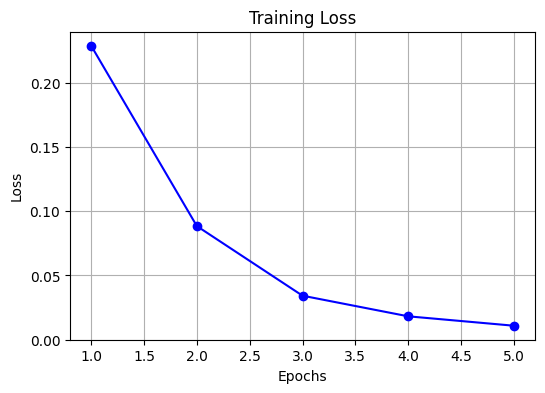

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)
resnet50 = resnet50.to(device)
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5
train_loss_values = []
accuracy_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    resnet50.train()
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = ce_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        accuracy = correct / total
        accuracy_list.append(accuracy)
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_loss_values.append(epoch_loss)
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [32]:
resnet50.eval()
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for inputs,labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
test_accuracy = (correct_predictions / total_predictions) * 100
print(f"Accuracy on Test Set: {test_accuracy:.2f}%")


Accuracy on Test Set: 97.50%


**Result demonstration**
* as you can see, we achieved `97.50%` accuracy score on the test set which is an astonishing performance

**Conclusions:**
in this section we loaded a resNet50 model with it's pretrained parameters, trained feature extractor with the `Triplet Loss`, trained fully connected output layer using `Cross entropy loss` to improve model performance. then we define the total loss below and again test model performance:
$$
L_{Total} = L_{CrossEntropy} + L_{Triplet}
$$

Epoch 10/10: 100%|██████████| 313/313 [12:22<00:00,  2.37s/batch, Total Loss=0.01]


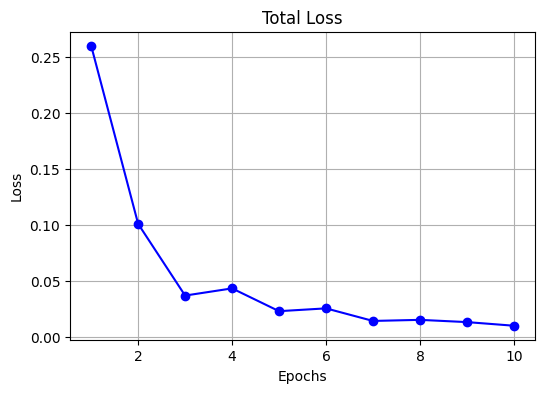

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)
criterion_CE = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10  # Set the number of epochs
total_loss_values = []
for epoch in range(num_epochs):
    running_total_loss = 0.0
    resnet50.train()
    pbar = tqdm(triplet_train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for anchor, positive, negative, labels in pbar:
        anchor, positive, negative, labels = anchor.to(device), positive.to(device), negative.to(device), labels.to(device)
        optimizer.zero_grad()
        anchor_embeddings = resnet50(anchor)
        positive_embeddings = resnet50(positive)
        negative_embeddings = resnet50(negative)
        logits = resnet50(anchor)  # Logits for the classification
        loss_triplet = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss_CE = criterion_CE(logits, labels)
        total_loss = loss_triplet + loss_CE
        total_loss.backward()
        optimizer.step()
        running_total_loss += total_loss.item()
        pbar.set_postfix({"Total Loss": running_total_loss / (len(train_loader))})
    epoch_total_loss = running_total_loss / len(train_loader)
    total_loss_values.append(epoch_total_loss)
    break

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), total_loss_values, marker='o', linestyle='-', color='b')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [42]:

resnet50.eval()
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate accuracy on the test set
test_accuracy = (correct_predictions / total_predictions) * 100
print(f"Accuracy on Test Set: {test_accuracy:.2f}%")


100%|██████████| 63/63 [00:09<00:00,  6.89it/s]

Accuracy on Test Set: 98.05%


**Finally, we achieve `98.05%` accuracy as the result of final model which is quite impressing**